In [1]:
# Mehran Hosseinzadeh
import torch
import copy
from collections import deque
import random
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
class DQN:

    def __init__(self, layer_nums, lr, copy_count, experience_replay_size):
        self.q_network = self.build_q_network(layer_nums)
        self.target_network = copy.deepcopy(self.q_network)
        self.q_network.cuda()
        self.target_network.cuda()
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)

        self.copy_count = copy_count
        self.counter = 0
        # testing different gammas
        # self.gamma = torch.tensor(1).float().cuda()
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen=experience_replay_size)
        return

    def build_q_network(self, layer_nums):
      # building layers as: linear connected layers with tanh activation, except for the last one where activation is y=x
        layers = []
        for i in range(len(layer_nums) - 1):
            linear_layer = torch.nn.Linear(layer_nums[i], layer_nums[i + 1])
            if i < len(layer_nums) - 2:
                layers += (linear_layer, torch.nn.Tanh())
            else:
                layers += (linear_layer, torch.nn.Identity())
        # building network in pytorch by array of designed layers
        return torch.nn.Sequential(*layers)

    # chossing action via epsioln greedy algorithm
    def get_action_from_q_network(self, state, action_space_len, epsilon):
        with torch.no_grad():
            q = self.q_network(torch.from_numpy(state).float().cuda())
        _, a = torch.max(q, axis=0)
        if torch.rand(1, ).item() < epsilon:
            return a
        else:
            return torch.randint(0, action_space_len, (1,))
    # chossing value via target network
    def get_q_next_from_target_network(self, state):
        with torch.no_grad():
            q = self.target_network(state)
        next_q, _ = torch.max(q, axis=1)
        return next_q

    def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        state = torch.tensor([experience[0] for experience in sample]).float()
        action = torch.tensor([experience[1] for experience in sample]).float()
        reward = torch.tensor([experience[2] for experience in sample]).float()
        next_state = torch.tensor([experience[3] for experience in sample]).float()
        return state, action, reward, next_state

    def train(self, batch_size):
        # experience replay
        state, action, reward, next_state = self.sample_from_experience(sample_size=batch_size)
        # updating target every copy_count iterations
        if self.counter % self.copy_count == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        self.counter += 1

        # predict expected return of current state using main network
        q = self.q_network(state.cuda())
        predicted_value, _ = torch.max(q, axis=1)

        # get target return using target network
        q_next = self.get_q_next_from_target_network(next_state.cuda())
        target_value = reward.cuda() + self.gamma * q_next

        # calc loss and back prop.
        loss = self.loss(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

        return loss.item()

In [7]:
env = gym.make('CartPole-v0')
input_dimension = env.observation_space.shape[0]
output_dimension = env.action_space.n
torch.manual_seed(1000)
experience_replay_size = 256
agent = DQN(layer_nums=[input_dimension, 64, 32, 16, output_dimension], lr=0.01, copy_count=5,
                  experience_replay_size=experience_replay_size)


rewards = []
num_episodes = 7500
epsilon = 1

# collecting first experience
j = 0
for i in range(experience_replay_size):
    observation = env.reset()
    done = False
    while not done and j <= experience_replay_size:
        A = agent.get_action_from_q_network(observation, env.action_space.n, epsilon=1)
        next_observation, reward, done, _ = env.step(A.item())
        agent.experience_replay.append([observation, A.item(), reward, next_observation])
        observation = next_observation
        j += 1

# traing after each k experiences are gathered
k = 128
for i in tqdm(range(num_episodes)):
    observation = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    while not done:
        A = agent.get_action_from_q_network(observation, env.action_space.n, epsilon)
        next_observation, reward, done, _ = env.step(A.item())
        agent.experience_replay.append([observation, A.item(), reward, next_observation])

        observation = next_observation
        total_reward += reward
        if k == 128:
            for j in range(4):
                loss = agent.train(batch_size=16)
                total_loss += loss
            k = 0
        else:
            k += 1
    # decreasing exploration as training goes on
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    rewards.append(total_reward)

100%|██████████| 7500/7500 [01:07<00:00, 111.72it/s]


Text(0, 0.5, 'Reward')

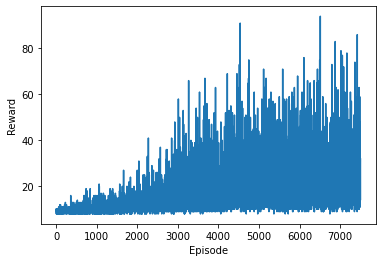

In [8]:
# plotting rewards as wanted
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
# as observed the reward is overally increasing